# Training Regression on wassa data

In [1]:
emoNames = ['anger','fear','joy','sadness']
# emoNames_hashTag = ['sadness', 'disgust', 'surprise', 'anger', 'fear', 'joy']

In [2]:
from nltk.tokenize import TweetTokenizer
import nltk.tokenize.casual as casual
from drevicko.twitter_regexes import cleanString, setupRegexes, tweetPreprocessor
import preprocess_twitter

def preprocess_tweet(text):    
    text = casual.reduce_lengthening(text)
    text = cleanString(setupRegexes('twitterProAna'),text)   
    text = ' '.join([span for notentity,span in tweetPreprocessor(text, ("urls", "users", "lists")) if notentity])
    text = text.replace('\t','')
    text = text.replace('< ','<').replace(' >','>')
    text = text.replace('):', '<sadface>').replace('(:', '<smile>')
    text = text.replace(" 't", "t").replace('#','')
    return text

def tokenise_tweet(text):
    text = preprocess_twitter.tokenize(text)
    text = preprocess_tweet(text)     
    return ' '.join(text.split())

tokenise_tweet.regexes = setupRegexes('twitterProAna')

imported regex as re


In [6]:
import subprocess

datasetList = ['http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/anger-ratings-0to1.train.txt',
'http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/fear-ratings-0to1.train.txt',
'http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/joy-ratings-0to1.train.txt',
'http://saifmohammad.com/WebDocs/EmoInt%20Train%20Data/sadness-ratings-0to1.train.txt',
'http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/anger-ratings-0to1.dev.gold.txt',
'http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/fear-ratings-0to1.dev.gold.txt',
'http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/joy-ratings-0to1.dev.gold.txt',
'http://saifmohammad.com/WebDocs/EmoInt%20Dev%20Data%20With%20Gold/sadness-ratings-0to1.dev.gold.txt',
'http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/anger-ratings-0to1.test.gold.txt',
'http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/fear-ratings-0to1.test.gold.txt',
'http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/joy-ratings-0to1.test.gold.txt',
'http://saifmohammad.com/WebDocs/EmoInt%20Test%20Gold%20Data/sadness-ratings-0to1.test.gold.txt']

# subprocess.run( ['wget'] + datasetList, stdout=subprocess.PIPE )

In [3]:
import os
import pandas as pd

def _read_csv_data(filename = "data.csv", header=True, columns=['id','tweet','emotion','label']):
    
    df = pd.DataFrame(pd.read_csv(filepath_or_buffer = filename,sep='\t',header=None))
    df.columns = columns
    
    tweets_list = []    
    for index, row in enumerate(df.iterrows()): 
        tweets_list.append(tokenise_tweet(row[1]['tweet']))     
    df['tweet'] = tweets_list

    return df

def get_input_files(directory):
    
    filenames_array = [filenames for root, dirnames, filenames in os.walk(directory)]
    files  = [val for sublist in filenames_array for val in sublist]
    
    return ["%s/%s" %(directory, file) for file in files if file.endswith(".txt")]

def _get_dfs():
    dfs_train, dfs_test, dfs_dev = {},{},{}
    
    for dir in get_input_files('data'):

        for emo in emoNames:
            if emo in dir:
                if 'train' in dir:
                    dfs_train.update( {emo : _read_csv_data(dir)} )                
                    print('train.'+emo+' \t' + str(len(dfs_train[emo])) + '\t<' + dir + '>')
                elif 'test.gold' in dir:
                    dfs_test.update( {emo : _read_csv_data(dir)} )                
                    print('test.'+emo+' \t' + str(len(dfs_test[emo])) + '\t<' + dir + '>')
                elif 'dev.gold' in dir:
                    dfs_dev.update( {emo : _read_csv_data(dir)} )                
                    print('dev.'+emo+' \t' + str(len(dfs_dev[emo])) + '\t<' + dir + '>')
                
    return {'train':dfs_train, 'test':dfs_test, 'dev':dfs_dev}

dfs = _get_dfs()    

dev.joy 	79	<data/joy-ratings-0to1.dev.gold.txt>
test.fear 	995	<data/fear-ratings-0to1.test.gold.txt>
dev.fear 	110	<data/fear-ratings-0to1.dev.gold.txt>
train.fear 	1147	<data/fear-ratings-0to1.train.txt>
dev.anger 	84	<data/anger-ratings-0to1.dev.gold.txt>
test.anger 	760	<data/anger-ratings-0to1.test.gold.txt>
dev.sadness 	74	<data/sadness-ratings-0to1.dev.gold.txt>
train.sadness 	786	<data/sadness-ratings-0to1.train.txt>
train.joy 	823	<data/joy-ratings-0to1.train.txt>
test.sadness 	673	<data/sadness-ratings-0to1.test.gold.txt>
test.joy 	714	<data/joy-ratings-0to1.test.gold.txt>
train.anger 	857	<data/anger-ratings-0to1.train.txt>


## WORD FREQUENCIES

In [6]:
from collections import Counter
from stop_words import get_stop_words
WORD_FREQUENCY_TRESHOLD = 3

import os
from sklearn.externals import joblib


def ifExists(filename):
    dir = os.path.dirname(filename)
    try:
        os.stat(dir)
    except:
        os.mkdir(dir) 
        
def checkFolder(filename):
    dir = os.path.dirname(filename)
    try:
        os.stat(dir)
    except:
        os.mkdir(dir) 

def _get_unique_tokens(tweets):    
    return(Counter(token for tweet in tweets for token in tweet.split()))

def _save_unique_tokens(tokens, filename='wordFrequencies.dump'):
    
    checkFolder(filename)
    _ = joblib.dump(tokens, filename=filename, compress=9)
    

def _plot_word_frequencies(wordFrequencies, WORD_FREQUENCY_TRESHOLD = 3):
    
    freqs = []
    for t,c in wordFrequencies.items():
        freqs.append(c)
        
    q = 0
    for t,c in wordFrequencies.items():
        if(c >= WORD_FREQUENCY_TRESHOLD):
            q+=1
    print(q, len(wordFrequencies))
    %pylab inline
    semilogy(arange(len(freqs)),sorted(freqs))
    show()
    

def _reduce_text(text, LANGUAGE='en', WORD_FREQUENCY_TRESHOLD = 3):    

    stop_words = get_stop_words(LANGUAGE)

    tweets_reduced = []

    for tw in tweets:
        tweet_r = []
        for token in tw.split():
            if(wordFrequencies[token] >= WORD_FREQUENCY_TRESHOLD):
                if(not token in stop_words):
                    tweet_r.append(token)

        tweets_reduced.append( ' '.join(tweet_r)  )
        
    return(tweets_reduced)

# Let the fun begin!

In [7]:
import numpy as np

seed = 1337
np.random.seed(seed)

# maxlen = 65
maxlen = 55
batch_size = 32
EMBEDDINGS_DIM = 100
nb_epoch = 50

hidden_dims1 = 50
hidden_dims2 = 25
hidden_dims3 = 3

path = '/home/vlaand/wassa2017'

_path_wordembeddings = '/home/vlaand/data/Glove/glove.twitter.27B/glove.twitter.27B.'+str(EMBEDDINGS_DIM)+'d.txt'

### Load training data and word embeddinbgs

In [8]:
import numpy as np
import pandas as pd
import csv

from keras.preprocessing import sequence
from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, Bidirectional, Dropout, LSTM
from keras.regularizers import l2

from imblearn.over_sampling import RandomOverSampler
# from sklearn.model_selection import StratifiedKFold

def _read_csv_data(filename = "data.csv", header=True):
    
    df = pd.read_csv(filepath_or_buffer = filename)     
    print('data loaded from <'+filename+'>')
    print('\t'+str(len(df))+' entries')    
    
    tweets_list = []    
    for row in df.iterrows():
        tweets_list.append([tokenise_tweet(row[1]['tweet'])] +[row[1][emo]for emo in emoNames])   
    return tweets_list

def _read_csv_we(filename = "data.csv"):
    
    embedding_index = {}

    for row in pd.read_csv(filepath_or_buffer=filename, sep = ' ', header=None).iterrows():
        word, coefs = row[1][0], np.asarray(row[1][1:])
        embedding_index[word] = coefs
        
    print('we vectors loaded from <'+filename+'>')
    print('\t'+str(len(embedding_index))+'\tentries')    
        
    return embedding_index


def _load_original_vectors(filename = 'wordvectors-glove.twitter.27B.100d.txt', sep = ' ', wordFrequencies = None):

    Dictionary, Indices  = {},{}
    i=1
    
    for line in open(filename, 'rb'): 
        values = line.decode('utf-8').split(sep)
        
        token = values[0]
        token_vector = np.array(values[1:], dtype = 'float32')   
        if(wordFrequencies):
            if(token in wordFrequencies):                
                Dictionary[token] = token_vector
                Indices.update({token:i})
                i+=1
        else:
            Dictionary[token] = token_vector
            Indices.update({token:i})
            i+=1
            
    print('we vectors loaded from <'+filename+'>')
    print('\t'+str(len(Dictionary))+' entries') 
    return(Dictionary, Indices)

def pretrainedEmbeddings(EmbeddingPath):
        embedding_index = {}
        
        with open(EmbeddingPath) as f:
            next(iter(f))
            embedding_wordsList = []
            for line in f:
                values = line.split(" ")
                word = values[0]
                coefs = np.asarray(values[1:])
                embedding_index[word] = coefs
                embedding_wordsList.append(word)
        
        return (embedding_index, embedding_wordsList)

def _texts_to_sequences(train_tweets):
    
    train_sequences = []
    for i,tweet in enumerate(train_tweets): 
        tw = []
        for token in tweet.split():
            try:
                tw.append(Indices[token])
            except:
                continue
        tw.extend([0]*( maxlen-len(tw)) )
        train_sequences.append(np.asarray(tw))
    return train_sequences

def _data_to_lists(dataTrain):    
    
    train_tweets, train_labels = [], []
    print('stacking data to lists')
    for i in dataTrain:
        scores = []
        for score in i[1:]:
            if np.isnan(score):
                scores.append( 0 )
                print('\tWarning: Nan value present in dataset')
            else:
                scores.append(score-2)
        train_labels.append(scores)
        train_tweets.append(i[0])
    print('data stacked to lists\n\t'+str(len(train_tweets))+' tweets\n\t'+str(len(train_labels))+' labels')
    return train_tweets, train_labels

Using Theano backend.


In [9]:
Dictionary, Indices = _load_original_vectors(
        filename = '/home/vlaand/data/Glove/glove.twitter.27B/glove.twitter.27B.'+str(EMBEDDINGS_DIM)+'d.txt', 
        sep = ' ',
        wordFrequencies = None)#wordFrequencies) # leave wordFrequencies=None for loading the entire WE file

Indices_reversed = {}
for key in Indices.keys():
    Indices_reversed.update({Indices[key]:key})

we vectors loaded from </home/vlaand/data/Glove/glove.twitter.27B/glove.twitter.27B.100d.txt>
	1193514 entries


#### Data conversion to an input to the model

In [10]:
def dataframe_to_lists(df):

    train_tweets, train_labels = [], []

    for row in df.iterrows():
        train_tweets.append(row[1][1])
        train_labels.append(row[1][3])
        
    return train_tweets, train_labels

def lists_to_vectors(train_tweets, train_labels):

    train_sequences = _texts_to_sequences(train_tweets)

    embedding_matrix = np.zeros((len(Indices)+1, EMBEDDINGS_DIM))

    print('matrix created\n\t',embedding_matrix.shape)
    for (word, i) in Indices.items():
        embedding_vector = Dictionary.get(word)
        if (embedding_vector != None):
            embedding_matrix[i] = embedding_vector.astype(np.float)

    _X = sequence.pad_sequences(train_sequences, maxlen=maxlen)
    _y = np.array(train_labels)

    print(len(_X), 'train sequences loaded')
    print('\t',_X.shape,'\n\t', _y.shape)
    
    return _X, _y, embedding_matrix

def _get_maxlen(tweets):
    max = 0
    for tw in tweets:
        if len(tw.split()) > max:
            max = len(tw.split())
    return max

### JUNCTION

sadness
max tweet length: 46 tokens
all tweets melted into list,  7102
4109 12927
Populating the interactive namespace from numpy and matplotlib


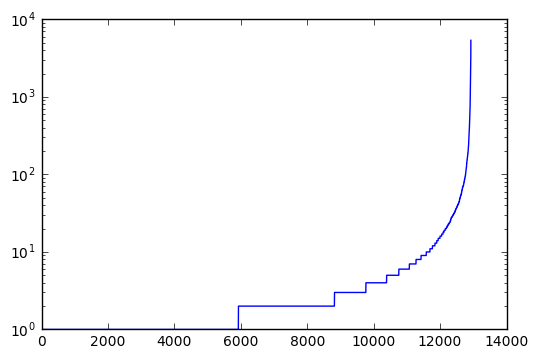

In [38]:
EMOTION = 3
print(emoNames[EMOTION])

train_tweets, train_labels = dataframe_to_lists(dfs['train'][emoNames[EMOTION]])
dev_tweets, dev_labels = dataframe_to_lists(dfs['dev'][emoNames[EMOTION]])
test_tweets, test_labels = dataframe_to_lists(dfs['test'][emoNames[EMOTION]])

print("max tweet length: %d tokens" %(_get_maxlen(train_tweets+dev_tweets+test_tweets)) )


meltTweets = []
# meltTweets.extend(train_tweets)
for dataset in ['train','test','dev']:
    for emo in emoNames:
        try:
            meltTweets.extend(dfs[dataset][emo]['tweet'])    
        except:
            print('KeyError: ',emo)
print('all tweets melted into list, ',len(meltTweets))

def _get_unique_tokens(tweets):    
    return(Counter(token for tweet in tweets for token in tweet.split()))

wordFrequencies = _get_unique_tokens(meltTweets) 
_plot_word_frequencies(wordFrequencies, WORD_FREQUENCY_TRESHOLD = WORD_FREQUENCY_TRESHOLD)

### Preparing for SVR

In [39]:
from sklearn.feature_extraction.text import CountVectorizer

def _save_ngramizer(ngramizer, filename = 'ngramizer.dump'):
    checkFolder(filename)
    _ = joblib.dump(ngramizer, filename=filename, compress=9)
    print('ngramizer saved\t<'+filename+'>')
    
def _load_ngramizer(filename = 'ngramizer.dump'):
    checkFolder(filename)
    ngramizer = joblib.load(filename = filename)
    print('ngramizer <'+filename+'> loaded')
    return ngramizer

NGRAM_VALUE = 4
WORD_FREQUENCY_TRESHOLD = 2
print('NGRAM_VALUE =',NGRAM_VALUE)
    
vectorizer = CountVectorizer(ngram_range = (1,NGRAM_VALUE),token_pattern=r'\b\w+\b', min_df=WORD_FREQUENCY_TRESHOLD,max_df=100)
# ngramizer = vectorizer.fit(meltTweets)
ngramizer = vectorizer.fit(train_tweets+dev_tweets)

vec = ngramizer.transform(train_tweets+dev_tweets).toarray()
print(len(vec), len(vec[0]))
    
_save_ngramizer(ngramizer, filename = '/home/vlaand/IpythonNotebooks/wassa2017/ngramizers/wassa_ngramizer_'+emoNames[EMOTION]+'.dump')

NGRAM_VALUE = 4
860 4746
ngramizer saved	</home/vlaand/IpythonNotebooks/wassa2017/ngramizers/wassa_ngramizer_sadness.dump>


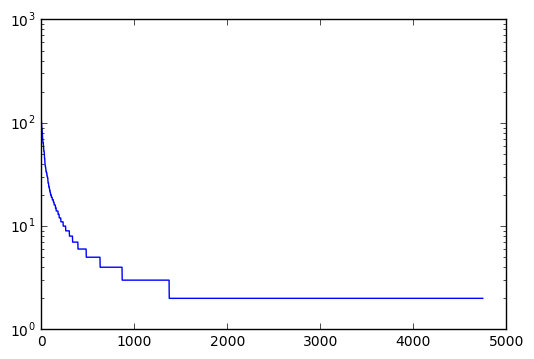

In [40]:
### NGRAM FREQUENCY

from natsort import natsorted
    
train_data_features = vec#X_train_counts.toarray()
vocab = ngramizer.get_feature_names()
dist = np.sum(train_data_features, axis=0)
ngram_freq = {}

# For each, print the vocabulary word and the frequency
for tag, count in zip(vocab, dist):
    #print(tag, count)
    ngram_freq[tag]=count

semilogy(natsorted(list(ngram_freq.values()),reverse=True))
show()

In [41]:
import numpy as np
import math, itertools
from scipy import spatial
def _vectors_similarity(v1 , v2):
    return( 1 - spatial.distance.cosine(v1,v2) )
def similarityVector(vector_, vectors_):
    resVector = np.asarray([_vectors_similarity(vector_ , v_) for v_ in vectors_])
    return np.asarray([np.max(resVector), np.mean(resVector), np.std(resVector), np.min(resVector)])
def compareTokenToSentence(leftToken, sentence):
    sentence_vectors = []
    for token in sentence:
        if token in Dictionary:
            sentence_vectors.append(Dictionary[token])
        else:
            token = token.replace('#','')
            if token in Dictionary:
                sentence_vectors.append(Dictionary[token])
    return similarityVector( Dictionary[leftToken], sentence_vectors)  
def capitalRatio(tweet):
        firstCap, allCap = 0, 0
        length = len(tweet)
        if length==0:
            return np.array([0,0])
        for i,token in enumerate(tweet.split()):
            if( token.istitle() ):
                firstCap += 1
            elif( token.isupper() ):
                allCap += 1
        return np.asarray([firstCap/length,allCap/length]) 
def tweetToWordVectors(dictionary, tweet, fixedLength=False):
    output = []    
    if(fixedLength):
        for i in range(MAX_SEQUENCE_LENGTH):
            output.append(blankVector)
        for i,token in enumerate(tweet.split()):
            if token in Dictionary:
                output[i] = Dictionary[token]                
    else:
         for i,token in enumerate(tweet.lower().split()):
            if token in Dictionary:
                output.append(Dictionary[token])
            elif token.replace('#','') in Dictionary:
                output.append(Dictionary[token.replace('#','')])
    return output
def ModWordVectors(x, mod=True):
    if(len(x) == 0):       
        if(mod):
            return(np.zeros(EMBEDDINGS_DIM*3, dtype='float32'))
        else:
            return(np.zeros(EMBEDDINGS_DIM, dtype='float32'))        
    m =  np.matrix(x)
    if(mod):
        xMean = np.array(m.mean(0))[0]
        xMin = np.array(m.min(0))[0]
        xMax = np.array(m.max(0))[0]
        xX = np.concatenate((xMean,xMin,xMax))
        return xX
    else:
        return np.array(m.mean(0))[0]
def bindTwoVectors(x0,x1):
    return np.array(list(itertools.chain(x0,x1)),dtype='float32') 
def _bind_vectors(x):
    return np.concatenate(x)   
def myLog10(vector):
    for i,v in enumerate(vector):
        if v > 0:
            vector[i] = np.log(v)
    return vector            
def _convert_text_to_vector(tweets,  Dictionary, labels, ngramizer):
    _X = []
    _y = []
    vec = ngramizer.transform(tweets).toarray()
    for i, t in enumerate(tweets):
        embeddingsVector = ModWordVectors(tweetToWordVectors(Dictionary,tweets[i]))
#         capitalRatioVector = capitalRatio(dfs[st][emoNames[EMOTION]][i])
        simVector = compareTokenToSentence(leftToken = emoNames[EMOTION], sentence = t)
        ngramVector = vec[i]
        _X.append( _bind_vectors((ngramVector, embeddingsVector, simVector))  )
#         _X.append( _bind_vectors((ngramVector, embeddingsVector))  )
        _y.append(labels[i])
    return(np.asarray(_X), np.asarray(_y))

In [14]:
svr_X, svr_y = _convert_text_to_vector(
    tweets = train_tweets+dev_tweets,
    labels = train_labels+dev_labels, 
    Dictionary = Dictionary, 
    ngramizer = ngramizer)

svr_X_train, svr_y_train = _convert_text_to_vector(
    tweets = train_tweets,
    labels = train_labels, 
    Dictionary = Dictionary, 
    ngramizer = ngramizer)

svr_X_dev, svr_y_dev = _convert_text_to_vector(
    tweets = dev_tweets,
    labels = dev_labels, 
    Dictionary = Dictionary, 
    ngramizer = ngramizer)

print('chosen emotion:', emoNames[EMOTION])
print('\tdata shape:\t', svr_X.shape, svr_y.shape)  
print('\tdata shape:\t', svr_X_train.shape, svr_y_train.shape)   
print('\tdata shape:\t', svr_X_dev.shape, svr_y_dev.shape)  

svr_X_test, svr_y_test = _convert_text_to_vector(
    tweets = test_tweets,
    labels = test_labels, 
    Dictionary = Dictionary, 
    ngramizer = ngramizer)

print('chosen emotion:', emoNames[EMOTION])
print('\tdata shape:\t', svr_X_test.shape, svr_y_test.shape)  

chosen emotion: sadness
	data shape:	 (860, 5050) (860,)
	data shape:	 (786, 5050) (786,)
	data shape:	 (74, 5050) (74,)
chosen emotion: sadness
	data shape:	 (673, 5050) (673,)


In [12]:
from sklearn.svm import SVR, LinearSVR
from sklearn.externals import joblib
from sklearn.metrics import f1_score, r2_score
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.metrics import r2_score, f1_score, classification_report
from scipy.stats import pearsonr, spearmanr
from collections import Counter
from multiprocessing import Pool
import warnings

In [124]:
warnings.simplefilter('ignore')

ESTIMATOR = 'SVR'
cv_folds = 5
# NGRAM_VALUE = 4

def _greed_search(EMOTION=0): 
#     y2 = []
#     for ly in y:
#         if not np.isnan(ly[EMOTION]):        
#             y2.append(float(ly[EMOTION])/4)
#         else:
#             y2.append(2.0)
#     y2 = np.asarray(y2)       

    list_acc = []    
    list_val = []
        
    if(ESTIMATOR == 'LinearSVR'):                             
        epsilon = 0.001
        gamma=1.0
#         C = 0.01
        for tol in [1e-6,1e-5,1e-4]:
            for C in [0.001,0.01,0.1,1.0,10.0]:
#                 cvs = cross_val_score(estimator = LinearSVR(C=C, tol=tol), X=X, y=y, cv=cv_folds, n_jobs=cv_folds, scoring='r2') 
#                 meanScore = np.mean(np.asarray(cvs))
    
                svcTrained = LinearSVR(C=C, tol=tol) 
                svcTrained.fit(svr_X_train, svr_y_train)

                svr_y_test_predict = svcTrained.predict(svr_X_dev)
                prs = pearsonr(svr_y_dev , svr_y_test_predict)[0]
                spr = spearmanr(svr_y_dev , svr_y_test_predict)[0]
                    
                list_val.append([emoNames[EMOTION],prs,ESTIMATOR, C, gamma,epsilon,tol,NGRAM_VALUE,EMBEDDINGS_DIM])
                list_acc.append(prs)
                print(emoNames[EMOTION]+': C='+str(C)+', tol='+str(tol)+', prs='+str(prs)+', spr='+str(spr))      
        
    elif(ESTIMATOR == 'SVR'):                          
        epsilon = 0.001
#         C = 1.0
#         tol = 1e-6
        gamma=0.01
        for tol in [1e-5,1e-4]:
            for gamma in [0.01,0.1,1.0,10.0]:       
            
                for C in [0.1,1.0]:                    
#                     cvs = [0.5,0.5,0.5]
#                     cvs = cross_val_score(estimator = SVR(C=C,gamma=gamma, tol=tol), X=X, y=y, cv=cv_folds, n_jobs=cv_folds, scoring='r2') 
#                     meanScore = np.mean(np.asarray(cvs))
                    svcTrained = SVR(C=C, tol=tol,gamma=gamma) 
                    svcTrained.fit(svr_X_train, svr_y_train)

                    svr_y_test_predict = svcTrained.predict(svr_X_dev)
                    prs = pearsonr(svr_y_dev , svr_y_test_predict)[0]
                    spr = spearmanr(svr_y_dev , svr_y_test_predict)[0]

                    list_val.append([emoNames[EMOTION],prs, ESTIMATOR, C, gamma,epsilon,tol,NGRAM_VALUE,EMBEDDINGS_DIM])
                    list_acc.append(prs)
                    print(emoNames[EMOTION]+': C='+str(C)+', gamma='+str(gamma)+', tol='+str(tol)+', prs='+str(prs)+', spr='+str(spr))
    
    best = np.argmax(list_acc)    
    print(list_val[best])
    out0 = {
        'C':list_val[best][3], 
        'gamma': list_val[best][4],
        'epsilon': list_val[best][5],
        'tol': list_val[best][6],
        'ngrams': list_val[best][7],
        'EMBEDDINGS_DIM': list_val[best][8],
        'score': list_val[best][1]
    }

    return {emoNames[EMOTION]:out0}
    
def _combine_best_results(pool_output, ESTIMATOR):
    new_p = {ESTIMATOR:{}}   
    for i in pool_output:
        new_p[ESTIMATOR].update(i)
        
    return new_p            

# p = 
# pool_output = p.map(_greed_search, [i for i in  range(len(emoNames))])  

# p.close()
# p.terminate() # Terminate all processes in the Pool

pool_output = [_greed_search(EMOTION)]
temp_params = _combine_best_results(pool_output, ESTIMATOR)

try:
    train_params[ESTIMATOR].update(temp_params[ESTIMATOR])
except:
    train_params = temp_params

fear: C=0.1, gamma=0.01, tol=1e-05, prs=0.599285401112, spr=0.553244563629
fear: C=1.0, gamma=0.01, tol=1e-05, prs=0.583469663975, spr=0.536969215183
fear: C=0.1, gamma=0.1, tol=1e-05, prs=0.303772789291, spr=0.421426871749
fear: C=1.0, gamma=0.1, tol=1e-05, prs=0.286210656703, spr=0.517649005261
fear: C=0.1, gamma=1.0, tol=1e-05, prs=0.134946699453, spr=0.151637870349
fear: C=1.0, gamma=1.0, tol=1e-05, prs=0.164062565836, spr=0.151637870349
fear: C=0.1, gamma=10.0, tol=1e-05, prs=0.113330677286, spr=0.111675791123
fear: C=1.0, gamma=10.0, tol=1e-05, prs=0.113330677286, spr=0.111675791123
fear: C=0.1, gamma=0.01, tol=0.0001, prs=0.599303913517, spr=0.553244563629
fear: C=1.0, gamma=0.01, tol=0.0001, prs=0.583483829497, spr=0.536969215183
fear: C=0.1, gamma=0.1, tol=0.0001, prs=0.303784561645, spr=0.421426871749
fear: C=1.0, gamma=0.1, tol=0.0001, prs=0.286220891137, spr=0.517987323203
fear: C=0.1, gamma=1.0, tol=0.0001, prs=0.134948565056, spr=0.151637870349
fear: C=1.0, gamma=1.0, tol

In [16]:
# train_params = {'SVR': {'anger': {'C': 1.0,
#    'EMBEDDINGS_DIM': 100,
#    'epsilon': 0.001,
#    'gamma': 0.01,
#    'ngrams': 4,
#    'score': 0.57150648623605949,
#    'tol': 0.0001},
#   'fear': {'C': 0.1,
#    'EMBEDDINGS_DIM': 100,
#    'epsilon': 0.001,
#    'gamma': 0.01,
#    'ngrams': 4,
#    'score': 0.5993039135165048,
#    'tol': 0.0001},
#   'joy': {'C': 0.1,
#    'EMBEDDINGS_DIM': 100,
#    'epsilon': 0.001,
#    'gamma': 0.01,
#    'ngrams': 4,
#    'score': 0.68525278230671982,
#    'tol': 1e-05},
#   'sadness': {'C': 0.1,
#    'EMBEDDINGS_DIM': 100,
#    'epsilon': 0.001,
#    'gamma': 10.0,
#    'ngrams': 4,
#    'score': nan,
#    'tol': 0.0001}},
#  'anger': {'nb_epoch': 12},
#  'fear': {'nb_epoch': 36},
#  'joy': {'nb_epoch': 8},
#  'sadness': {'nb_epoch': 18}}
train_params

{'SVR': {'anger': {'C': 1.0,
   'EMBEDDINGS_DIM': 100,
   'epsilon': 0.001,
   'gamma': 0.01,
   'ngrams': 4,
   'score': 0.5715064862360595,
   'tol': 0.0001},
  'fear': {'C': 0.1,
   'EMBEDDINGS_DIM': 100,
   'epsilon': 0.001,
   'gamma': 0.01,
   'ngrams': 4,
   'score': 0.5993039135165048,
   'tol': 0.0001},
  'joy': {'C': 0.1,
   'EMBEDDINGS_DIM': 100,
   'epsilon': 0.001,
   'gamma': 0.01,
   'ngrams': 4,
   'score': 0.6852527823067198,
   'tol': 1e-05},
  'sadness': {'C': 0.1,
   'EMBEDDINGS_DIM': 100,
   'epsilon': 0.001,
   'gamma': 10.0,
   'ngrams': 4,
   'score': nan,
   'tol': 0.0001}},
 'anger': {'nb_epoch': 12},
 'fear': {'nb_epoch': 36},
 'joy': {'nb_epoch': 8},
 'sadness': {'nb_epoch': 18}}

In [17]:
svcTrained = SVR(C=train_params['SVR'][emoNames[EMOTION]]['C'], 
                 tol=train_params['SVR'][emoNames[EMOTION]]['tol'], 
                 gamma=train_params['SVR'][emoNames[EMOTION]]['gamma']) 
# svcTrained.fit(svr_X_train, svr_y_train)
svcTrained.fit(svr_X, svr_y)

SVR(C=0.1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=10.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.0001, verbose=False)

In [137]:
svr_y_dev_predict = svcTrained.predict(svr_X_dev)
y_dev_predict = np.array([y_[0] for y_ in model.predict(X_dev)])
mix_y_dev_predict = np.array([ np.mean([y1,y2]) for y1,y2 in zip(y_dev_predict, svr_y_dev_predict) ])

print("%8s\t%.2f\t%.2f\t%.2f" % (emoNames[EMOTION]+'.svr',
                                 r2_score(svr_y_dev , svr_y_dev_predict),                                 
                                 pearsonr(svr_y_dev , svr_y_dev_predict)[0],
                                 spearmanr(svr_y_dev , svr_y_dev_predict)[0]))
print("%8s\t%.2f\t%.2f\t%.2f" % (emoNames[EMOTION]+'.lstm',
                                 r2_score(y_dev , y_dev_predict),                                 
                                 pearsonr(y_dev , y_dev_predict)[0],
                                 spearmanr(y_dev , y_dev_predict)[0]))
print("%8s\t%.2f\t%.2f\t%.2f" % (emoNames[EMOTION]+'.avg',
                                 r2_score(y_dev , mix_y_dev_predict),                                 
                                 pearsonr(y_dev , mix_y_dev_predict)[0],
                                 spearmanr(y_dev , mix_y_dev_predict)[0]))

fear.svr	0.61	0.87	0.84
fear.lstm	0.98	0.99	0.99
fear.avg	0.90	0.98	0.98


fear.svr	0.30	0.60	0.55
fear.lstm	0.33	0.62	0.58
fear.avg	0.40	0.64	0.59

sadness.svr	    0.24	0.52	0.54
sadness.lstm	0.19	0.52	0.57
sadness.avg	    0.30	0.55	0.58

Populating the interactive namespace from numpy and matplotlib


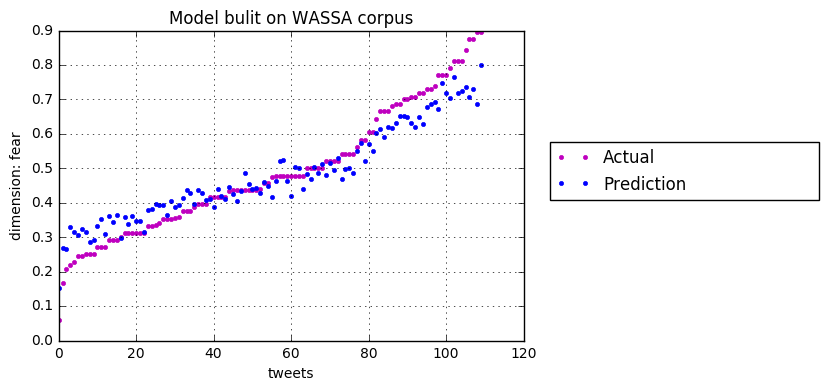

In [140]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import natsort

dimension = EMOTION

s = y_dev#[:, dimension] #y_annotated[dimension]
order = sorted(range(len(s)), key=lambda k: s[k])

g1 = y_dev#[:, dimension]
g2 = mix_y_dev_predict#[yy[dimension] for yy in y_wassa_test_predict]#[:, dimension]    

line_0, = plt.plot(np.array(g1)[order], 'm.',  label='Actual')
line_1, = plt.plot(np.array(g2)[order], 'b.', label='Prediction')
plt.grid(True)
plt.legend(handles=[line_0, line_1])
plt.legend(bbox_to_anchor=(1.02, .4, .65, .0), loc=3,ncol=1, mode="expand", borderaxespad=1.0)
plt.ylabel('dimension: '+emoNames[dimension])
plt.xlabel('tweets')
plt.title("Model bulit on WASSA corpus")
plt.show()

### Preparing for LSTM

In [42]:
X_train, y_train, embedding_matrix = lists_to_vectors(train_tweets, train_labels)
X_dev, y_dev, embedding_matrix = lists_to_vectors(dev_tweets, dev_labels)
X_test, y_test, embedding_matrix = lists_to_vectors(test_tweets, test_labels)

X, y, embedding_matrix = lists_to_vectors(train_tweets+dev_tweets+test_tweets, train_labels+dev_labels+test_labels)

matrix created
	 (1193515, 100)


/home/vlaand/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:20: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


786 train sequences loaded
	 (786, 55) 
	 (786,)
matrix created
	 (1193515, 100)
74 train sequences loaded
	 (74, 55) 
	 (74,)
matrix created
	 (1193515, 100)
673 train sequences loaded
	 (673, 55) 
	 (673,)
matrix created
	 (1193515, 100)
1533 train sequences loaded
	 (1533, 55) 
	 (1533,)


## Training on WASSA dataset

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import StratifiedKFold
from multiprocessing import Pool, Manager
import os
import numpy as np

import keras.backend as K

def matthews_correlation(y_true, y_pred):
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos

    y_pos = K.round(K.clip(y_true, 0, 1))
    y_neg = 1 - y_pos

    tp = K.sum(y_pos * y_pred_pos)
    tn = K.sum(y_neg * y_pred_neg)

    fp = K.sum(y_neg * y_pred_pos)
    fn = K.sum(y_pos * y_pred_neg)

    numerator = (tp * tn - fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

In [261]:
def _cross_validation_parallel(_input):
    train, test = _input
    
    model = Sequential()
    model.add(Embedding(len(Indices)+1,  EMBEDDINGS_DIM, weights=[embedding_matrix],
                                input_length=maxlen, trainable=True))
    model.add(Bidirectional(LSTM(EMBEDDINGS_DIM))) #dropout is same as regularisation
    model.add(Dropout(0.2))
    model.add(Dense(hidden_dims1, W_regularizer=l2(0.01)), )
    model.add(Dense(hidden_dims2, W_regularizer=l2(0.01)), ) #!!!
    model.add(Dense(hidden_dims3, activation='softsign'))
    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['accuracy', matthews_correlation])
        
    model.fit(X[train], y[train], batch_size=batch_size, nb_epoch=nb_epoch, validation_split=None)
    
#     scores = model.evaluate(X[test], y[test], verbose=0,)
    y_test_predict = model.predict(X[test])
    y_test_predict = np.reshape(y_test_predict, newshape=(len(y_test_predict),))
    
    scores =  [r2_score(y_test_predict, y[test]), pearson(y_test_predict, y[test]), spearman(y_test_predict, y[test])]

    print("%s: %.2f" % (model.metrics_names[2], scores[1]))
    return scores

nb_epoch = 10
n_splits = 5
hidden_dims1 = 50
hidden_dims2 = 25
hidden_dims3 = 1
np.random.seed(1337)

# with open('senpy-plugins-development/fivePointRegression/classifiers/LSTM/log.out', "w") as log_file:
#     log_file.write(str(cvscores)+'\n')
#     log_file.write("%.2f (+/- %.2f%%)" % (np.mean(cvscores), np.std(cvscores)))

kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=1337)

with Pool(processes = n_splits) as p:
    cvscores = p.map(_cross_validation_parallel, ((train, test) for (train, test) in kfold.split(X, y)))

# print("%.2f (+/- %.2f)" % (np.mean(cvscores), np.std(cvscores)))


print('%s' % (emoNames[EMOTION].upper()))
print('%d folds, %d epochs' % (n_splits,nb_epoch))
print()

my_metrics = ['r2_score', 'pearson', 'spearman']
for func in range(3):
    print("%s:\t%.2f (+/- %.2f)" % (my_metrics[func],np.mean([i[func] for i in cvscores]), np.std([i[func] for i in cvscores])))

# p._pool[0].is_alive()

JOY
5 folds, 50 epochs

r2_score:	0.03 (+/- 0.18)
pearson:	0.67 (+/- 0.05)
spearman:	0.65 (+/- 0.05)


## Final Training

In [44]:
try:
    train_params.update({
        'anger':{'nb_epoch':12},
        'joy':{'nb_epoch':8},
        'fear':{'nb_epoch':36},
        'sadness':{'nb_epoch':18 }
    })
except:
    train_params = {
        'anger':{'nb_epoch':12},
        'joy':{'nb_epoch':8},
        'fear':{'nb_epoch':36},
        'sadness':{'nb_epoch':18 }
    }

In [45]:
hidden_dims1 = 50
hidden_dims2 = 25
hidden_dims3 = 1
model = Sequential()
model.add(Embedding(len(Indices)+1,  EMBEDDINGS_DIM, weights=[embedding_matrix],
                            input_length=maxlen, trainable=True))
model.add(Bidirectional(LSTM(EMBEDDINGS_DIM))) #dropout is same as regularisation
model.add(Dropout(0.2))
model.add(Dense(hidden_dims1, b_regularizer=l2(0.01)), )
model.add(Dense(hidden_dims2, b_regularizer=l2(0.01)), ) 
model.add(Dense(hidden_dims3, activation='softsign'))
model.compile(loss='mean_absolute_error', optimizer='adam', metrics=[matthews_correlation])

model.fit(X, y, batch_size=batch_size, nb_epoch=train_params[emoNames[EMOTION]]['nb_epoch'],validation_split=None,)

Epoch 1/18
1533/1533 [==============================] - 60s - loss: 0.2004 - matthews_correlation: 0.0835    
Epoch 2/18
1533/1533 [==============================] - 61s - loss: 0.1466 - matthews_correlation: 0.2682    
Epoch 3/18
1533/1533 [==============================] - 63s - loss: 0.1334 - matthews_correlation: 0.4459    
Epoch 4/18
1533/1533 [==============================] - 61s - loss: 0.1146 - matthews_correlation: 0.5677    
Epoch 5/18
1533/1533 [==============================] - 61s - loss: 0.0973 - matthews_correlation: 0.6495    
Epoch 6/18
1533/1533 [==============================] - 59s - loss: 0.0857 - matthews_correlation: 0.7228    
Epoch 7/18
1533/1533 [==============================] - 58s - loss: 0.0791 - matthews_correlation: 0.7560    
Epoch 8/18
1533/1533 [==============================] - 57s - loss: 0.0695 - matthews_correlation: 0.7780    
Epoch 9/18
1533/1533 [==============================] - 60s - loss: 0.0651 - matthews_correlation: 0.8086    
Epoch 10/1

In [47]:
# y_t_pred = model.predict(X_dev)

y_dev_pred = np.array([y_[0] for y_ in model.predict(X_dev)])
print(min(y_dev_pred), max(y_dev_pred))
print("%8s\t%.2f\t%.2f\t%.2f" % (emoNames[EMOTION],
                                 r2_score(y_dev , y_dev_pred),                                 
                                 pearsonr(y_dev , y_dev_pred)[0],
                                 spearmanr(y_dev , y_dev_pred)[0]))

0.191175 0.842128
 sadness	0.85	0.93	0.93


In [20]:
from sklearn.metrics import r2_score, f1_score, classification_report
# from skll.metrics import pearson, spearman
from scipy.stats import pearsonr, spearmanr


# print('[%8s]\tR2\tpearson\tspearman' % emoNames[EMOTION])
# y_dev_predicts = []
# for i in range(20):
#     if i>0: 
#         model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=1,validation_split=None,)
#     y_dev_pred = np.array([y_[0] for y_ in model.predict(X_dev)])
#     print("%8s\t%.2f\t%.2f\t%.2f" % (i,
#                                  r2_score(y_dev , y_dev_pred),                                 
#                                  pearsonr(y_dev , y_dev_pred)[0],
#                                  spearmanr(y_dev , y_dev_pred)[0]))    
#     y_dev_predicts.append(y_dev_pred)


# model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch,validation_split=None,)

In [73]:
print('[%8s]\tR2\tpearson\tspearman' % emoNames[EMOTION])
for i,y__ in enumerate(y_dev_predicts):  
        y_test_predict = y__
        print("%8s\t%.2f\t%.2f\t%.2f" % (i,
                                 r2_score(y_dev , y_test_predict),                                 
                                 pearsonr(y_dev , y_test_predict)[0],
                                 spearmanr(y_dev , y_test_predict)[0]))

[ sadness]	R2	pearson	spearman
       0	-0.40	-0.12	-0.13
       1	0.07	0.43	0.44
       2	0.17	0.53	0.54
       3	0.11	0.46	0.50
       4	0.21	0.49	0.54
       5	0.17	0.47	0.49
       6	0.21	0.48	0.54
       7	0.11	0.56	0.59
       8	0.14	0.50	0.56
       9	0.20	0.49	0.54
      10	0.10	0.48	0.52
      11	0.16	0.51	0.54
      12	0.18	0.50	0.53
      13	0.15	0.50	0.55
      14	0.18	0.51	0.53
      15	0.18	0.51	0.55
      16	0.19	0.52	0.56
      17	0.21	0.53	0.54
      18	0.23	0.54	0.56
      19	0.17	0.50	0.54


Populating the interactive namespace from numpy and matplotlib


/home/vlaand/anaconda3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['dist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


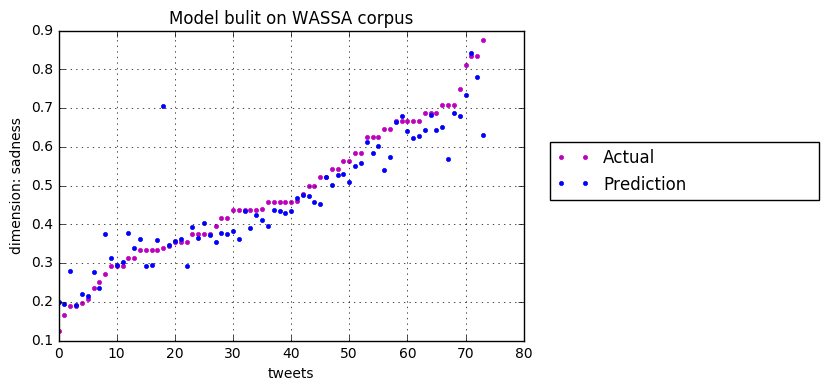

In [48]:
%pylab inline
import numpy as np
import matplotlib.pyplot as plt
import natsort

dimension = EMOTION

s = y_dev#[:, dimension] #y_annotated[dimension]
order = sorted(range(len(s)), key=lambda k: s[k])

g1 = y_dev#[:, dimension]
g2 = y_dev_pred#[yy[dimension] for yy in y_wassa_test_predict]#[:, dimension]    

line_0, = plt.plot(np.array(g1)[order], 'm.',  label='Actual')
line_1, = plt.plot(np.array(g2)[order], 'b.', label='Prediction')
plt.grid(True)
plt.legend(handles=[line_0, line_1])
plt.legend(bbox_to_anchor=(1.02, .4, .65, .0), loc=3,ncol=1, mode="expand", borderaxespad=1.0)
plt.ylabel('dimension: '+emoNames[dimension])
plt.xlabel('tweets')
plt.title("Model bulit on WASSA corpus")
plt.show()

#### Method 1 (save architecture and weights separately)

In [49]:
def _save_model_wassa(model, savePath, emo, modelName):
    if emo == None:
        savePath = os.path.join(savePath,modelName)
    else:
        savePath = os.path.join(savePath,modelName)+"."+emo
        
    model_json = model.to_json()
    with open(savePath + ".json", "w") as json_file:
        json_file.write(model_json)
        print("<%s.json> " % (savePath))
        
    model.save_weights(savePath +".h5", overwrite=True)
    print("<%s.h5> " % (savePath))
    
#     model.save(savePath + "_.h5")
    
# savePath = "/home/vlaand/IpythonNotebooks/senpy-plugins-NUIG/fivePointRegression/classifiers/LSTM/"
savePath = "/home/vlaand/IpythonNotebooks/05_emotion_wassa_nuig/wassaRegression/classifiers/LSTM/"

_save_model_wassa(model=model, savePath=savePath, emo=emoNames[EMOTION], modelName="wassaRegression")
_save_model_wassa(model=model, savePath='/home/vlaand/IpythonNotebooks/wassa2017/classifiers/LSTM/', emo=emoNames[EMOTION], modelName="wassaRegression")

emoNames[EMOTION]

</home/vlaand/IpythonNotebooks/05_emotion_wassa_nuig/wassaRegression/classifiers/LSTM/wassaRegression.sadness.json> 
</home/vlaand/IpythonNotebooks/05_emotion_wassa_nuig/wassaRegression/classifiers/LSTM/wassaRegression.sadness.h5> 
</home/vlaand/IpythonNotebooks/wassa2017/classifiers/LSTM/wassaRegression.sadness.json> 
</home/vlaand/IpythonNotebooks/wassa2017/classifiers/LSTM/wassaRegression.sadness.h5> 


'sadness'

In [359]:
from keras.models import model_from_json

with open('/home/vlaand/IpythonNotebooks/wassa2017/classifiers/LSTM/wassaRegression.'+emoNames[EMOTION]+'.json', 'r') as json_file:
    loaded_model = model_from_json(json_file.read())
    loaded_model.load_weights(json_file.name.replace('.json','.h5'))
    print('<%s> loaded' %(json_file.name))
    print('<%s> weights loaded' % (json_file.name.replace('.json','.h5')))

</home/vlaand/IpythonNotebooks/wassa2017/classifiers/LSTM/wassaRegression.anger.json> loaded
</home/vlaand/IpythonNotebooks/wassa2017/classifiers/LSTM/wassaRegression.anger.h5> weights loaded
